In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os 
os.chdir('../')
from python.create_dgl_dataset import create_dgl_dataset,TelemacDataset
from python.python_code.data_manip.extraction.telemac_file import TelemacFile

import torch
from tqdm import trange
import copy
import pandas as pd
import random
import dgl

In [2]:
res_list = ['./gnn_modulus_project/data/simulations/maillage_3/simu_Q_2500_intermediaire/TetQ2500_intermediaire.res']
mesh_list = ['./gnn_modulus_project/data/simulations/maillage_3/simu_Q_2500_intermediaire/maillage_3.slf']
cli_list = ['./gnn_modulus_project/data/simulations/maillage_3/simu_Q_2500_intermediaire/cli']
dt_list = [1]

data_folder = './gnn_modulus_project/data/'
dataset_name = 'TetQ2500inter'

In [3]:
create_mesh = False
if create_mesh :
    create_dgl_dataset(mesh_list,res_list,cli_list,dt_list,data_folder,dataset_name)

In [4]:
graphs, _ = dgl.load_graphs(data_folder+'/'+dataset_name+'.bin') 

In [5]:
print(len(graphs))

70


In [16]:
from python.create_dgl_dataset import add_mesh_info
ts = 1
one_hot = graphs[ts].ndata['x'][:,:4]
h = graphs[ts].ndata['x'][:,4:5]
u = graphs[ts].ndata['x'][:,5:6]
v = graphs[ts].ndata['x'][:,6:7]
k = graphs[ts].ndata['x'][:,7:8]
hstar = graphs[ts].ndata['y'][:,0:1]
res_mesh = TelemacFile(mesh_list[0])
X,triangles = add_mesh_info(res_mesh)

In [17]:
print(X.shape)

(412844, 2)


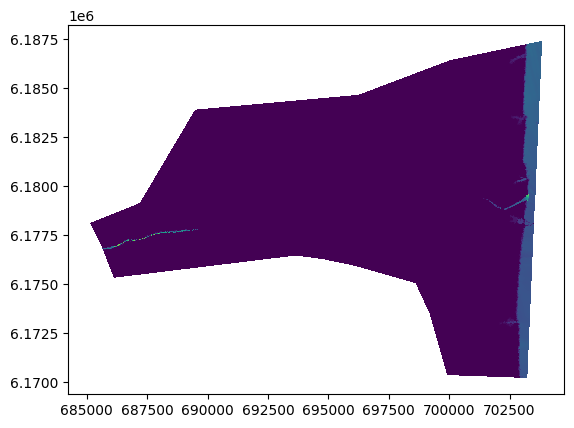

In [18]:
plt.figure()
plt.tripcolor(X[:,0],X[:,1],h[:,0],triangles=triangles)
plt.show()

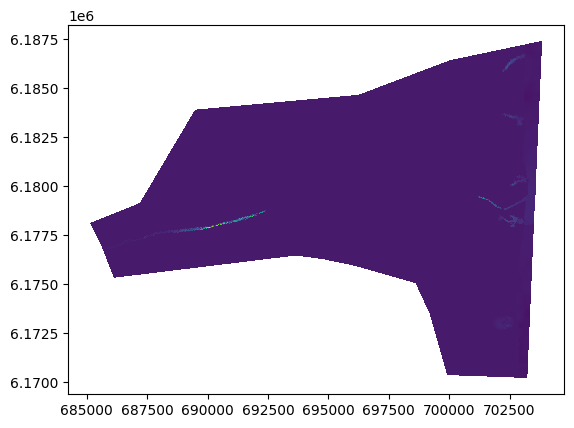

In [19]:
plt.figure()
plt.tripcolor(X[:,0],X[:,1],hstar[:,0],triangles=triangles)
plt.show()

In [10]:
import networkx as nx

In [35]:
def reachable_nodes(g, start_node, x):
    reachable = torch.full((g.num_nodes(),), False, dtype=torch.bool)
    current_frontier = torch.tensor([start_node], dtype=torch.int64)
    reachable[current_frontier] = True

    for _ in range(x + 3):  # Extend to x+3 to accommodate the larger radius
        if _ == x:
            within_x_reachable = reachable.clone()
        current_frontier = g.in_edges(current_frontier)[0]
        reachable[current_frontier] = True
    
    return within_x_reachable, reachable

def extract_and_visualize_subgraph(g, start_node, x):
    # Get nodes reachable within x and x+3 hops
    within_x_reachable, within_x_plus_3_reachable = reachable_nodes(g, start_node, x)

    # Extract subgraph for nodes within x+3 hops
    subgraph = g.subgraph(torch.nonzero(within_x_plus_3_reachable, as_tuple=True)[0])

    # Convert to NetworkX graph for visualization
    nx_g = subgraph.to_networkx().to_undirected()

    # Prepare node colors: red for within x hops, blue for x+1 to x+3 hops
    color_map = []
    for node_id in nx_g.nodes():
        if within_x_reachable[node_id]:
            color_map.append('red')
        else:
            color_map.append('blue')

    # Visualization
    plt.figure(figsize=(10, 10))
    nx.draw(nx_g, node_color=color_map, with_labels=True, node_size=50, font_color='white')
    plt.title(f"Subgraph Visualization within {x} (red) and {x+3} (blue) Hops from Node {start_node}")
    plt.show()


In [31]:
g = graphs[ts]
input_bd_index = np.where((g.ndata['x'][:,:4].numpy()==[0,0,1,0]).all(axis=1))[0][5]
reachable = reachable_nodes(g, input_bd_index, 4)


In [34]:
# Convert DGL graph to networkx graph for visualization
nx_g = g.to_networkx().to_undirected()

# Node colors
color_map = ['red' if reachable[i] else 'blue' for i in range(g.num_nodes())]

# Draw the graph using a different method
plt.figure(figsize=(8, 8))
nx.draw_networkx(nx_g, node_color=color_map, with_labels=True, node_size=700, font_color='white')
plt.show()

KeyboardInterrupt: 

<Figure size 800x800 with 0 Axes>